# Setup

In [1]:
# Set the folders containing annotated data
lineage_folder = "data/ablation-lineage/"
czi_folder = "data/ablation-czi/"

# Load data

## Parse lineage files

In [ ]:
import os
import glob
import pandas as pd

# Set the folder containing .lineage files
pattern = os.path.join(lineage_folder, "*.lineage")
files = sorted(glob.glob(pattern))

if not files:
    raise FileNotFoundError(f"No .lineage files found in {lineage_folder!r}")

out_rows = []
point_id_counter = 0

for p in files:
    cell_id = os.path.splitext(os.path.basename(p))[0]
    try:
        df = pd.read_csv(p, sep="\t", comment="#", engine="python")
    except Exception as e:
        print(f"Warning: failed to read {p!r}: {e}")
        continue
    required = {"cell", "time", "x", "y"}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        print(f"Warning: skipping {p!r}: missing columns {', '.join(sorted(missing))}")
        continue
    valid_mask = df["cell"].str.startswith("New nucleus") | df["cell"].str.startswith("cut")
    df = df[valid_mask].copy()
    if df.empty:
        print(f"Warning: skipping {p!r}: no valid points found")
        continue
    result = df[["cell", "time", "x", "y"]].copy()
    result["cut"] = result["cell"].apply(lambda x: x.startswith("cut"))
    result["cell_id"] = cell_id
    cell_names = result["cell"].unique()
    cell_to_point_id = {name: point_id_counter + i for i, name in enumerate(cell_names)}
    result["point_id"] = result["cell"].map(cell_to_point_id)
    result = result.drop(columns=["cell"])
    point_id_counter += len(cell_names)
    out_rows.append(result)

if not out_rows:
    raise ValueError("No valid data parsed from .lineage files.")

print(f"Parsed data for {point_id_counter} unique points from {len(out_rows)} files.")

points = pd.concat(out_rows, ignore_index=True)
points = points[["point_id", "cell_id", "cut", "time", "x", "y"]]

points.head()

Parsed data for 1981 unique points from 181 files.


,point_id,cell_id,cut,time,x,y
0,0,220530-E1_Out,False,3,368.0,192.0
1,1,220530-E1_Out,False,3,306.0,251.0
2,2,220530-E1_Out,False,3,374.0,224.0
3,3,220530-E1_Out,False,3,323.0,202.0
4,4,220530-E1_Out,False,3,325.0,218.0


## Remove timepoints before cut

In [4]:
# Find the earliest cut timepoint for each cell_id
cut_times = points[points["cut"] == True].groupby("cell_id")["time"].min()

# Initialize the mask as a boolean Series
keep_mask = pd.Series(True, index=points.index, dtype=bool)

for cell_id in points["cell_id"].unique():
    cell_mask = points["cell_id"] == cell_id
    
    if cell_id in cut_times.index:
        first_cut_time = cut_times[cell_id]
        time_mask = (points.loc[cell_mask, "time"] >= first_cut_time - 1)
        
        # Cast time_mask to numpy array or boolean Series explicitly
        keep_mask.loc[cell_mask] = time_mask.astype(bool).values

# Apply mask
points = points[keep_mask].reset_index(drop=True)
points.head()

,point_id,cell_id,cut,time,x,y
0,0,220530-E1_Out,False,3,368.0,192.0
1,1,220530-E1_Out,False,3,306.0,251.0
2,2,220530-E1_Out,False,3,374.0,224.0
3,3,220530-E1_Out,False,3,323.0,202.0
4,4,220530-E1_Out,False,3,325.0,218.0


## Parse czi files

In [5]:
import os
import numpy as np
import czifile as cz
import xml.etree.ElementTree as ET

df = points.copy()

# Get unique cell_ids
cell_ids =df['cell_id'].unique()

processed_groups = []
for cell_id in cell_ids:
    cell_mask = df['cell_id'] == cell_id
    cell_df = df[cell_mask].copy()
    czi_filename = f"{cell_id}.czi"
    czi_path = os.path.join(czi_folder, czi_filename)

    if not os.path.exists(czi_path):
        print(f"Warning: CZI file not found for cell_id {cell_id!r} (expected {czi_filename})")
        cell_df['timestamp'] = np.nan
        processed_groups.append(cell_df)
        continue

    # Open the CZI file once
    with cz.CziFile(czi_path) as czi:
        # 1. Extract timestamps
        timestamps = None
        for attachment in czi.attachments():
            if attachment.attachment_entry.name == 'TimeStamps':
                timestamps = attachment.data()
                break

        if timestamps is None:
            print(f"Warning: No timestamps found in {czi_path}")
            cell_df['timestamp'] = np.nan
        else:
            frames = cell_df["time"].values
            frames = np.clip(frames, 0, len(timestamps) - 1)
            cell_df['timestamp'] = timestamps[frames]

        # 2. Extract pixel scaling
        xml_metadata = czi.metadata()
        root = ET.fromstring(xml_metadata)
        scaling_x = root.find('.//{*}Scaling/{*}Items/{*}Distance[@Id="X"]/{*}Value')
        scaling_y = root.find('.//{*}Scaling/{*}Items/{*}Distance[@Id="Y"]/{*}Value')

        pixel_x = float(scaling_x.text) * 1e6 if scaling_x is not None else None
        pixel_y = float(scaling_y.text) * 1e6 if scaling_y is not None else None

    # Convert coordinates
    if pixel_x is not None and pixel_y is not None:
        cell_df['x_pixel_size'] = pixel_x
        cell_df['y_pixel_size'] = pixel_y
    else:
        print(f"Warning: Pixel size information not found for {czi_path}.")

    processed_groups.append(cell_df)

# Concatenate all processed groups
points_irl = pd.concat(processed_groups, ignore_index=True)

# points_irl now contains the mapped timestamps and coordinates in micrometers
points_irl.head()


,point_id,cell_id,cut,time,x,y,timestamp,x_pixel_size,y_pixel_size
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355
1,1,220530-E1_Out,False,3,306.0,251.0,2731.228878,0.050355,0.050355
2,2,220530-E1_Out,False,3,374.0,224.0,2731.228878,0.050355,0.050355
3,3,220530-E1_Out,False,3,323.0,202.0,2731.228878,0.050355,0.050355
4,4,220530-E1_Out,False,3,325.0,218.0,2731.228878,0.050355,0.050355


# Calculate coordinates relative to cut

In [6]:
# Calculate cut-based coordinates (x_parallel, x_perpendicular, cut_length) with cut1 as the cut with lowest y value
import numpy as np

df = points_irl.copy()

for cell_id in df["cell_id"].unique():
    cell_mask = df["cell_id"] == cell_id
    cell_df = df[cell_mask]
    cut_points = cell_df[cell_df["cut"] == True]
    if len(cut_points) > 2:
        print(f"Warning: cell_id {cell_id!r} has more than 2 cut points; skipping cut coordinate calculation.")
        continue
    if len(cut_points) < 2:
        print(f"Warning: cell_id {cell_id!r} has less than 2 cut points; skipping cut coordinate calculation.")
        continue

    # Sort cut points so cut1 is the one with lowest y value
    cut_points_sorted = cut_points.sort_values("y", ascending=False)
    cut1 = cut_points_sorted.iloc[0]
    cut2 = cut_points_sorted.iloc[1]

    cut_vector = np.array([cut2["x"] - cut1["x"], cut2["y"] - cut1["y"]])
    cut_length = np.linalg.norm(cut_vector)

    if cut_length == 0:
        print(f"Warning: cell_id {cell_id!r} has identical cut points; skipping cut coordinate calculation.")
        continue

    cut_unit = cut_vector / cut_length
    perp_unit = np.array([-cut_unit[1], cut_unit[0]])
    origin = np.array([cut1["x"], cut1["y"]])

    for idx in cell_df.index:
        point = np.array([df.loc[idx, "x"], df.loc[idx, "y"]])
        relative_pos = point - origin
        df.loc[idx, "x_parallel"] = np.dot(relative_pos, cut_unit) / cut_length
        df.loc[idx, "x_perpendicular"] = np.dot(relative_pos, perp_unit)
        df.loc[idx, "cut_length"] = cut_length

# Remove points that are not within cut length
df = df[(df['x_parallel'] >= 0) & (df['x_parallel'] <= 1)]

points_cut = df.copy()
points_cut.head()

,point_id,cell_id,cut,time,x,y,timestamp,x_pixel_size,y_pixel_size,x_parallel,x_perpendicular,cut_length
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,0.781787,28.094557,93.434469
1,1,220530-E1_Out,False,3,306.0,251.0,2731.228878,0.050355,0.050355,0.089347,-27.934017,93.434469
2,2,220530-E1_Out,False,3,374.0,224.0,2731.228878,0.050355,0.050355,0.447079,37.149031,93.434469
3,3,220530-E1_Out,False,3,323.0,202.0,2731.228878,0.050355,0.050355,0.628866,-15.732952,93.434469
4,4,220530-E1_Out,False,3,325.0,218.0,2731.228878,0.050355,0.050355,0.460481,-12.201065,93.434469


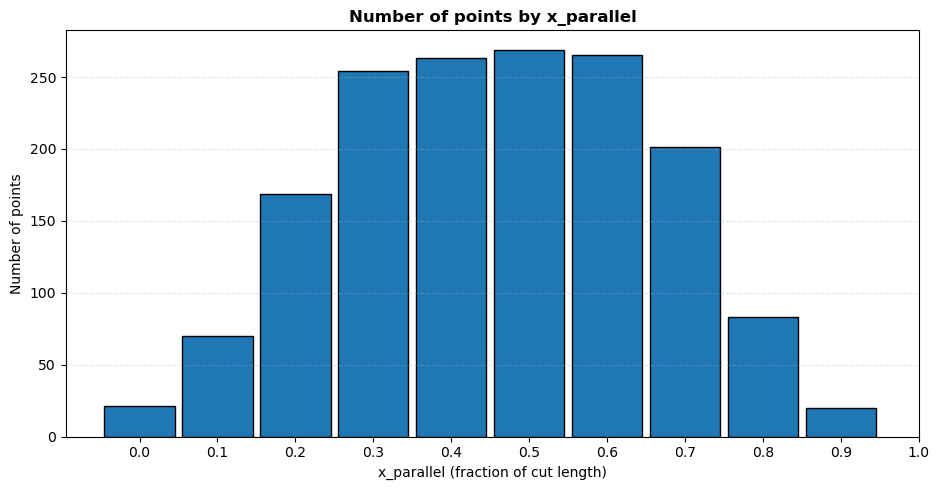

In [8]:
import matplotlib.pyplot as plt
import numpy as np

df = points_cut.copy()
bin_length = 0.1  # x_parallel bin width (fraction of cut length)

# Drop NaNs in required columns
df = df.dropna(subset=['x_parallel'])

# Only look at the first timepoint in each cell (right before cut)
first_timepoints = df.groupby('cell_id')['time'].min().reset_index()
df = df.merge(first_timepoints, on=['cell_id', 'time'])

# Bin x_parallel (relative to cut length)
df['x_parallel_bin'] = np.floor(df['x_parallel'] / bin_length) * bin_length

# Count unique point_ids per x_parallel bin
point_counts = df.groupby('x_parallel_bin')['point_id'].nunique().reset_index()

plt.figure(figsize=(9.5, 5))
plt.bar(point_counts['x_parallel_bin'], point_counts['point_id'], width=bin_length*0.9, align='center', edgecolor='black')
plt.xlabel('x_parallel (fraction of cut length)')
plt.ylabel('Number of points')
plt.title('Number of points by x_parallel', fontweight='bold')
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# X-axis ticks
min_x = df['x_parallel'].min()
max_x = df['x_parallel'].max()
if max_x > min_x:
    plt.xticks(np.arange(np.floor(min_x), np.ceil(max_x) + bin_length, bin_length))

plt.tight_layout()
plt.show()

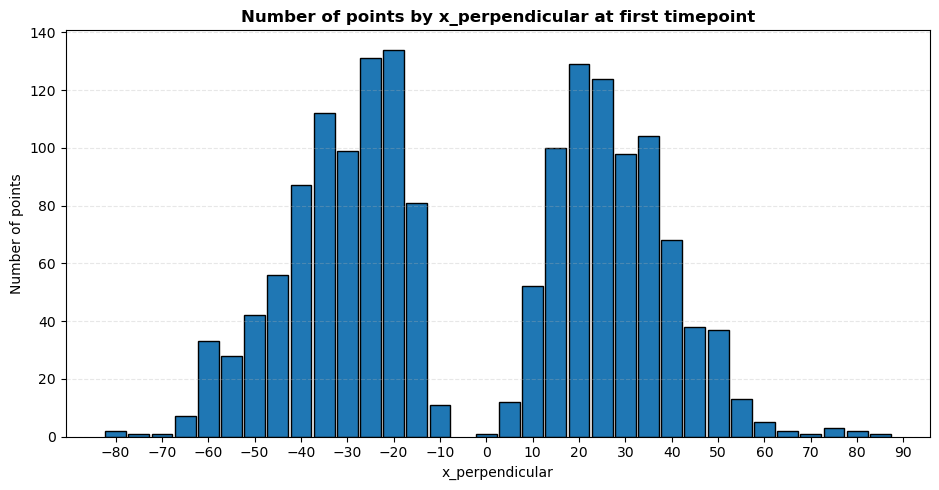

In [29]:
import matplotlib.pyplot as plt
import numpy as np

df = points_cut.copy()
bin_length = 5  # x_parallel bin width (fraction of cut length)

# Drop NaNs in required columns
df = df.dropna(subset=['x_perpendicular'])

# Only look at the first timepoint in each cell (right before cut)
first_timepoints = df.groupby('cell_id')['time'].min().reset_index()
df = df.merge(first_timepoints, on=['cell_id', 'time'])

# Bin x_perpendicular (relative to cut length)
df['x_perpendicular_bin'] = np.floor(df['x_perpendicular'] / bin_length) * bin_length

# Count unique point_ids per x_perpendicular bin
point_counts = df.groupby('x_perpendicular_bin')['point_id'].nunique().reset_index()

plt.figure(figsize=(9.5, 5))
plt.bar(point_counts['x_perpendicular_bin'], point_counts['point_id'], width=bin_length*0.9, align='center', edgecolor='black')
plt.xlabel('x_perpendicular')
plt.ylabel('Number of points')
plt.title('Number of points by x_perpendicular at first timepoint', fontweight='bold')
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# X-axis ticks
min_x = df['x_perpendicular'].min()
max_x = df['x_perpendicular'].max()
if max_x > min_x:
    plt.xticks(np.arange(np.floor(min_x-3), np.ceil(max_x) + bin_length, bin_length*2))

plt.tight_layout()
plt.show()

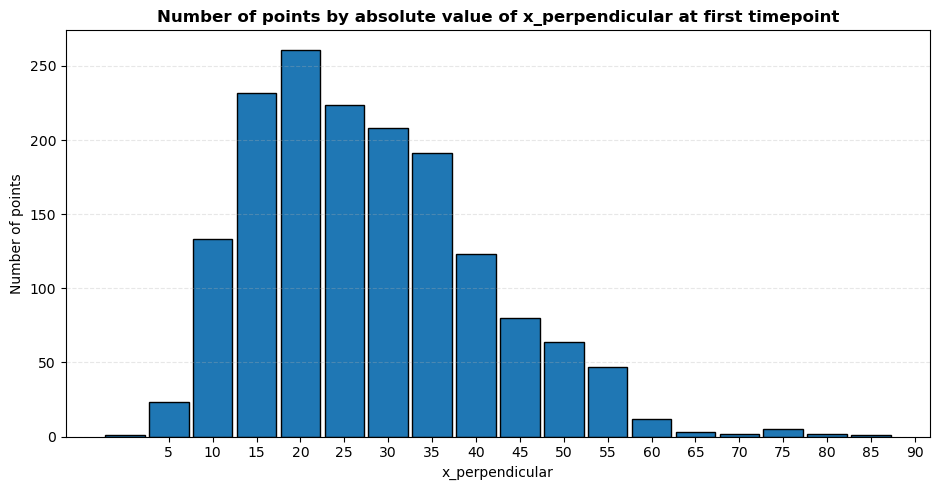

In [22]:
import matplotlib.pyplot as plt
import numpy as np

df = points_cut.copy()
bin_length = 5  # x_parallel bin width (fraction of cut length)

# Drop NaNs in required columns
df = df.dropna(subset=['x_perpendicular'])

# Only look at the first timepoint in each cell (right before cut)
first_timepoints = df.groupby('cell_id')['time'].min().reset_index()
df = df.merge(first_timepoints, on=['cell_id', 'time'])

# Use absolute value
df['x_perpendicular'] = df['x_perpendicular'].abs()

# Bin x_perpendicular (relative to cut length)
df['x_perpendicular_bin'] = np.floor(df['x_perpendicular'] / bin_length) * bin_length

# Count unique point_ids per x_perpendicular bin
point_counts = df.groupby('x_perpendicular_bin')['point_id'].nunique().reset_index()

plt.figure(figsize=(9.5, 5))
plt.bar(point_counts['x_perpendicular_bin'], point_counts['point_id'], width=bin_length*0.9, align='center', edgecolor='black')
plt.xlabel('x_perpendicular')
plt.ylabel('Number of points')
plt.title('Number of points by absolute value of x_perpendicular at first timepoint', fontweight='bold')
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# X-axis ticks
min_x = df['x_perpendicular'].min()
max_x = df['x_perpendicular'].max()
if max_x > min_x:
    plt.xticks(np.arange(np.floor(min_x + 1), np.ceil(max_x) + bin_length, bin_length))

plt.tight_layout()
plt.show()

In [70]:
from IPython.display import HTML

# animate x_perpendicular distribution over time offsets (start at -1)
import matplotlib.animation as animation

df = points_cut.copy()
df = df.dropna(subset=['x_perpendicular'])

cut_times = df.loc[df['cut']].groupby('cell_id')['time'].min()
df['cut_time'] = df['cell_id'].map(cut_times)
df = df[~df['cut_time'].isna()].copy()
df['offset'] = df['time'] - df['cut_time']

# Exclude points where cut is True
df = df[df['cut'] == False]

start_offset = -1
end_offset = int(df['offset'].max())
offsets = np.arange(start_offset, end_offset + 1)

bin_length = 5.0
max_abs = np.ceil(df['x_perpendicular'].abs().max())
bins = np.arange(0.0, max_abs + bin_length, bin_length)  # bin edges (left edges: bins[:-1])
bin_centers = bins[:-1] + bin_length / 2.0

fig, ax = plt.subplots(figsize=(9.5, 5))
bars = ax.bar(bin_centers, np.zeros_like(bin_centers), width=bin_length * 0.9, align='center', edgecolor='black')
ax.set_xlabel('x_perpendicular (abs, pixels)')
ax.set_ylabel('Number of points')
title = ax.set_title('')
text_info = ax.text(0.99, 0.95, '', transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-bin_length, bin_centers.max() + bin_length)
ax.set_ylim(0, max(5, df['point_id'].nunique() * 0.1))  # initial ylimit; will adjust if needed
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

def compute_heights(offset):
    tdf = df[df['offset'] == offset].copy()
    if tdf.empty:
        return np.zeros(len(bin_centers)), 0
    tdf['bin'] = np.floor(tdf['x_perpendicular'].abs() / bin_length) * bin_length
    counts = tdf.groupby('bin')['point_id'].nunique()
    heights = np.array([counts.get(left, 0) for left in bins[:-1]])
    total = tdf['point_id'].nunique()
    return heights, total

def init():
    for rect in bars:
        rect.set_height(0)
    title.set_text('')
    text_info.set_text('')
    return list(bars) + [title, text_info]

def update(i):
    offset = offsets[i]
    heights, total = compute_heights(offset)
    # expand ylimit if needed
    current_ylim = ax.get_ylim()
    max_h = heights.max() if heights.size else 0
    if max_h > current_ylim[1] * 0.95:
        ax.set_ylim(0, max_h * 1.2 + 1)
    for rect, h in zip(bars, heights):
        rect.set_height(h)
    title.set_text(f'Number of points by |x_perpendicular| at cut_time + {offset}')
    text_info.set_text(f'offset={offset}   total points={total}')
    return list(bars) + [title, text_info]

anim = animation.FuncAnimation(fig, update, frames=len(offsets), init_func=init,
                               blit=True, interval=800, repeat=False)

plt.close(fig)
HTML(anim.to_jshtml())

# Calculate time relative to first tracked point per cell and point velocities

In [30]:
import numpy as np

df = points_cut.copy()  # or use your DataFrame variable

# Compute velocity
df["dx"] = df.groupby("point_id")["x"].diff()
df["dy"] = df.groupby("point_id")["y"].diff()
df["dt"] = df.groupby("point_id")["timestamp"].diff()
df["vx"] = np.where(df["dt"] > 0, df["dx"] / df["dt"], np.nan)
df["vy"] = np.where(df["dt"] > 0, df["dy"] / df["dt"], np.nan)
df["velocity"] = np.sqrt(df["vx"]**2 + df["vy"]**2)

# Add absolute time since first tracked frame in the cell
df["t_rel"] = df["timestamp"] - df.groupby("cell_id")["timestamp"].transform("min")

# Clean up intermediate columns
df = df.drop(columns=["dx", "dy"])

# Calculate cut velocities
df = df.sort_values(["point_id", "timestamp"]).reset_index(drop=True)
df["dx_parallel"] = df.groupby("point_id")["x_parallel"].diff()
df["dx_perpendicular"] = df.groupby("point_id")["x_perpendicular"].diff()
df["dt"] = df.groupby("point_id")["timestamp"].diff()
df["v_parallel"] = np.where(df["dt"] > 0, df["dx_parallel"] / df["dt"], np.nan)
df["v_perpendicular"] = np.where(df["dt"] > 0, df["dx_perpendicular"] / df["dt"], np.nan)
df["velocity_cut"] = np.sqrt(df["v_parallel"]**2 + df["v_perpendicular"]**2)

# Clean up intermediate columns
df = df.drop(columns=["dx_parallel", "dx_perpendicular", "dt"])

points_v = df.copy()

points_v.head()

,point_id,cell_id,cut,time,x,y,timestamp,x_pixel_size,y_pixel_size,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,t_rel,v_parallel,v_perpendicular,velocity_cut
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,0.781787,28.094557,93.434469,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,0.050355,0.050355,0.784880,31.080607,93.434469,1.081092,0.000000,1.081092,2.774971,0.001115,1.076065,1.076066
2,0,220530-E1_Out,False,5,372.0,193.0,2734.999678,0.050355,0.050355,0.775258,32.172281,93.434469,1.004189,1.004189,1.420137,3.770800,-0.009662,1.096247,1.096289
3,0,220530-E1_Out,False,6,374.0,194.0,2736.011395,0.050355,0.050355,0.766667,34.259305,93.434469,1.976838,0.988419,2.210172,4.782517,-0.008492,2.062854,2.062872
4,0,220530-E1_Out,False,7,375.0,194.0,2737.007224,0.050355,0.050355,0.767698,35.254655,93.434469,1.004189,0.000000,1.004189,5.778346,0.001035,0.999519,0.999520


# Remove points with unrealistic velocities

In [42]:
df = points_v.copy() 

filter_threshold = 11  # Velocity threshold

initial_count = df['point_id'].nunique()

to_remove = []
for pid in df['point_id'].unique():
    vals = df.loc[df['point_id'] == pid, 'velocity_cut']
    if vals.dropna().empty:
        continue
    if (vals.abs() > filter_threshold).any():
        to_remove.append(pid)

if to_remove:
    df = df[~df['point_id'].isin(to_remove)]

final_count = df['point_id'].nunique()
diff_count = initial_count - final_count

print(f"Total filtered out: {diff_count} point{"s" if diff_count != 1 else ""} based on velocity threshold {filter_threshold}")

points_v_filtered = df.copy()

points_v_filtered.head()

Total filtered out: 23 points based on velocity threshold 11


,point_id,cell_id,cut,time,x,y,timestamp,x_pixel_size,y_pixel_size,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,t_rel,v_parallel,v_perpendicular,velocity_cut
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,0.781787,28.094557,93.434469,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,0.050355,0.050355,0.784880,31.080607,93.434469,1.081092,0.000000,1.081092,2.774971,0.001115,1.076065,1.076066
2,0,220530-E1_Out,False,5,372.0,193.0,2734.999678,0.050355,0.050355,0.775258,32.172281,93.434469,1.004189,1.004189,1.420137,3.770800,-0.009662,1.096247,1.096289
3,0,220530-E1_Out,False,6,374.0,194.0,2736.011395,0.050355,0.050355,0.766667,34.259305,93.434469,1.976838,0.988419,2.210172,4.782517,-0.008492,2.062854,2.062872
4,0,220530-E1_Out,False,7,375.0,194.0,2737.007224,0.050355,0.050355,0.767698,35.254655,93.434469,1.004189,0.000000,1.004189,5.778346,0.001035,0.999519,0.999520


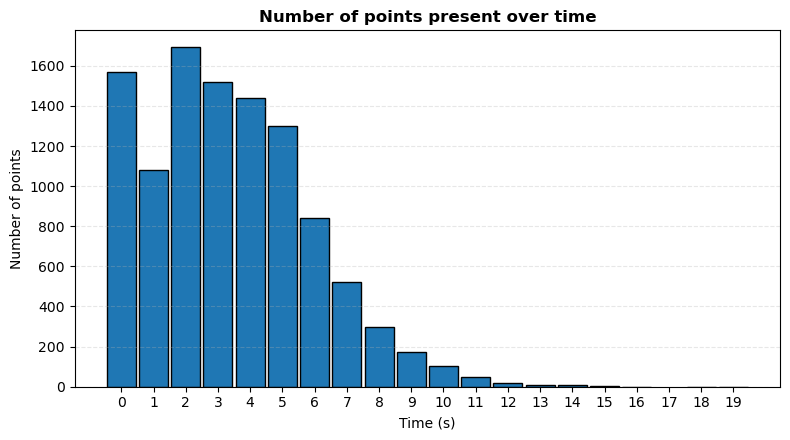

In [43]:
import matplotlib.pyplot as plt
import numpy as np

df = points_v_filtered.copy()
bin_length = 1  # seconds

df = df.dropna(subset=['t_rel'])
df['ts_bin'] = np.floor(df['t_rel'] / bin_length) * bin_length

# Count unique point_ids per bin
point_counts = df.groupby('ts_bin')['point_id'].nunique().reset_index()

plt.figure(figsize=(8, 4.5))
plt.bar(point_counts['ts_bin'], point_counts['point_id'], width=bin_length*0.9, align='center', edgecolor='black')
plt.xlabel('Time (s)')
plt.ylabel('Number of points')
plt.title('Number of points present over time', fontweight='bold')
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# X-axis ticks
min_time = df['t_rel'].min()
max_time = df['t_rel'].max()
if max_time > min_time:
    plt.xticks(np.arange(int(np.floor(min_time)), int(np.ceil(max_time)), 1))

plt.tight_layout()
plt.show()

# Remove points that were not sampled frequently enough

In [44]:
# Keep only points present at least every 3s from t_rel=0 to t_rel=6 
import numpy as np

df = points_v_filtered.copy()

required_times = np.arange(1.5, 6.01, 3)  # 1.5, 4.5
keep_point_ids = []
for pid, group in df.groupby('point_id'):
    t_rels = group['t_rel'].dropna().values
    # Keep cut points
    if group['cut'].any():
        keep_point_ids.append(pid)
        continue
    # For each required time, check if there is a point within +/-1.5s (to allow for some jitter)
    if all(np.any(np.abs(t_rels - t) <= 1.5) for t in required_times):
        keep_point_ids.append(pid)

df = df[df['point_id'].isin(keep_point_ids)].copy()

print(f"After time coverage filter: {len(keep_point_ids)} points remain with coverage from t_rel=0 to 6 every 3s (±1.5s tolerance)")

points_t_filtered = df.copy()
points_t_filtered.head()


After time coverage filter: 1855 points remain with coverage from t_rel=0 to 6 every 3s (±1.5s tolerance)


,point_id,cell_id,cut,time,x,y,timestamp,x_pixel_size,y_pixel_size,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,t_rel,v_parallel,v_perpendicular,velocity_cut
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,0.781787,28.094557,93.434469,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,0.050355,0.050355,0.784880,31.080607,93.434469,1.081092,0.000000,1.081092,2.774971,0.001115,1.076065,1.076066
2,0,220530-E1_Out,False,5,372.0,193.0,2734.999678,0.050355,0.050355,0.775258,32.172281,93.434469,1.004189,1.004189,1.420137,3.770800,-0.009662,1.096247,1.096289
3,0,220530-E1_Out,False,6,374.0,194.0,2736.011395,0.050355,0.050355,0.766667,34.259305,93.434469,1.976838,0.988419,2.210172,4.782517,-0.008492,2.062854,2.062872
4,0,220530-E1_Out,False,7,375.0,194.0,2737.007224,0.050355,0.050355,0.767698,35.254655,93.434469,1.004189,0.000000,1.004189,5.778346,0.001035,0.999519,0.999520


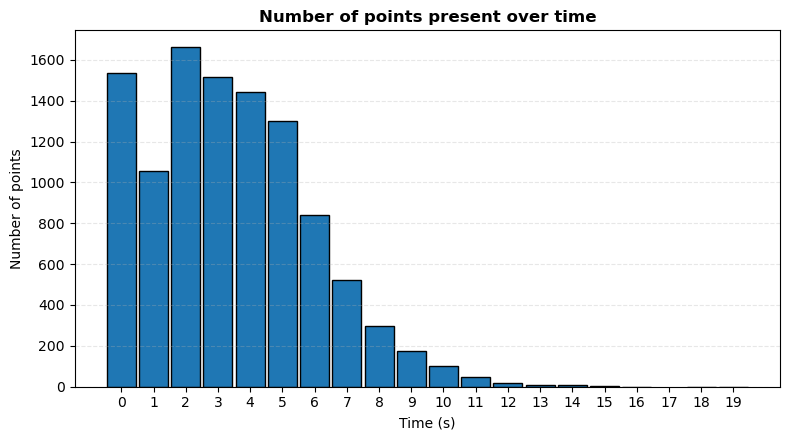

In [45]:
import matplotlib.pyplot as plt
import numpy as np

df = points_t_filtered.copy()
bin_length = 1  # seconds

df = df.dropna(subset=['t_rel'])
df['ts_bin'] = np.floor(df['t_rel'] / bin_length) * bin_length

# Count unique point_ids per bin
point_counts = df.groupby('ts_bin')['point_id'].nunique().reset_index()

plt.figure(figsize=(8, 4.5))
plt.bar(point_counts['ts_bin'], point_counts['point_id'], width=bin_length*0.9, align='center', edgecolor='black')
plt.xlabel('Time (s)')
plt.ylabel('Number of points')
plt.title('Number of points present over time', fontweight='bold')
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# X-axis ticks
min_time = df['t_rel'].min()
max_time = df['t_rel'].max()
if max_time > min_time:
    plt.xticks(np.arange(int(np.floor(min_time)), int(np.ceil(max_time)), 1))

plt.tight_layout()
plt.show()

# Remove points after 10 seconds (not informative)

In [46]:
# Remove points after t_rel=10
df = points_t_filtered.copy()
df = df[df['t_rel'] < 11].copy()
points_final = df.copy()
points_final.head()

,point_id,cell_id,cut,time,x,y,timestamp,x_pixel_size,y_pixel_size,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,t_rel,v_parallel,v_perpendicular,velocity_cut
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,0.781787,28.094557,93.434469,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,0.050355,0.050355,0.784880,31.080607,93.434469,1.081092,0.000000,1.081092,2.774971,0.001115,1.076065,1.076066
2,0,220530-E1_Out,False,5,372.0,193.0,2734.999678,0.050355,0.050355,0.775258,32.172281,93.434469,1.004189,1.004189,1.420137,3.770800,-0.009662,1.096247,1.096289
3,0,220530-E1_Out,False,6,374.0,194.0,2736.011395,0.050355,0.050355,0.766667,34.259305,93.434469,1.976838,0.988419,2.210172,4.782517,-0.008492,2.062854,2.062872
4,0,220530-E1_Out,False,7,375.0,194.0,2737.007224,0.050355,0.050355,0.767698,35.254655,93.434469,1.004189,0.000000,1.004189,5.778346,0.001035,0.999519,0.999520


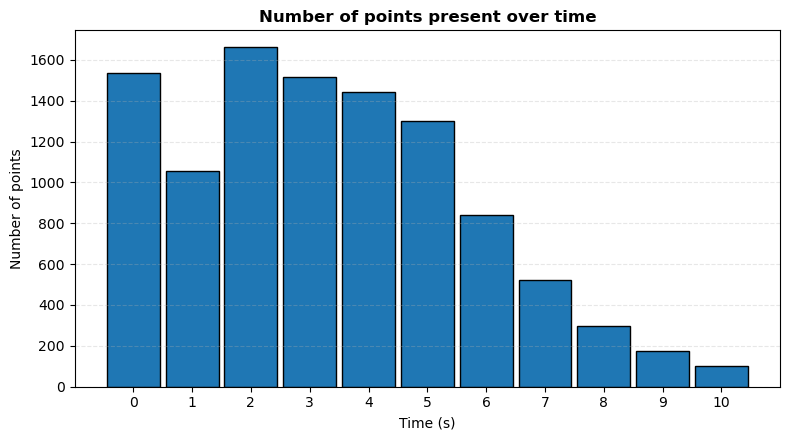

In [47]:
import matplotlib.pyplot as plt
import numpy as np

df = points_final.copy()
bin_length = 1  # seconds

df = df.dropna(subset=['t_rel'])
df['ts_bin'] = np.floor(df['t_rel'] / bin_length) * bin_length

# Count unique point_ids per bin
point_counts = df.groupby('ts_bin')['point_id'].nunique().reset_index()

plt.figure(figsize=(8, 4.5))
plt.bar(point_counts['ts_bin'], point_counts['point_id'], width=bin_length*0.9, align='center', edgecolor='black')
plt.xlabel('Time (s)')
plt.ylabel('Number of points')
plt.title('Number of points present over time', fontweight='bold')
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# X-axis ticks
min_time = df['t_rel'].min()
max_time = df['t_rel'].max()
if max_time > min_time:
    plt.xticks(np.arange(int(np.floor(min_time)), int(np.ceil(max_time)), 1))

plt.tight_layout()
plt.show()

# Output csv file

In [48]:
points_final.to_csv('out/points.csv')

# Velocity analysis

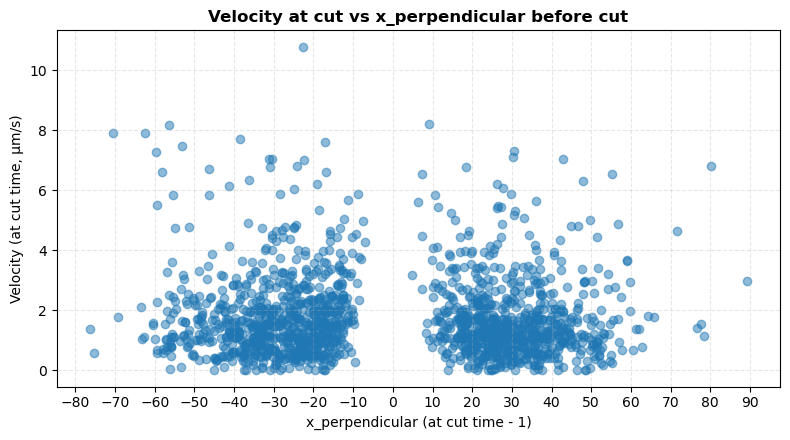

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = points_final.copy()

# 1. Identify the cut time for each cell
cut_times = df.loc[df["cut"]].groupby("cell_id")["time"].min()

# 2. Get rows at the cut time (velocity at cut)
cut_df = df[df["time"].isin(cut_times)].copy()

# 3. Get rows at cut time - 1 (x_perpendicular before cut)
precut_df = df.copy()
precut_df["cut_time"] = precut_df["cell_id"].map(cut_times)
precut_df = precut_df[precut_df["time"] == precut_df["cut_time"] - 1]

# 4. Merge precut x_perpendicular with cut velocity
merged = pd.merge(
    cut_df[["point_id", "velocity_cut"]],
    precut_df[["point_id", "x_perpendicular"]],
    on="point_id",
    how="inner"
)

# 5. Drop missing values just in case
merged = merged.dropna(subset=["x_perpendicular", "velocity_cut"])

# 6. Scatter plot
plt.figure(figsize=(8, 4.5))
plt.scatter(merged["x_perpendicular"], merged["velocity_cut"], alpha=0.5)
plt.xlabel("x_perpendicular (at cut time - 1)")
plt.ylabel("Velocity (at cut time, pixels/s)")
plt.title("Velocity at cut vs x_perpendicular before cut", fontweight="bold")
plt.grid(True, alpha=0.3, linestyle="--")

# Optional: nice ticks on x-axis
min_x = merged["x_perpendicular"].min()
max_x = merged["x_perpendicular"].max()
if max_x > min_x:
    plt.xticks(np.arange(np.floor(min_x - 3), np.ceil(max_x) + 10, 10))

plt.tight_layout()
plt.show()


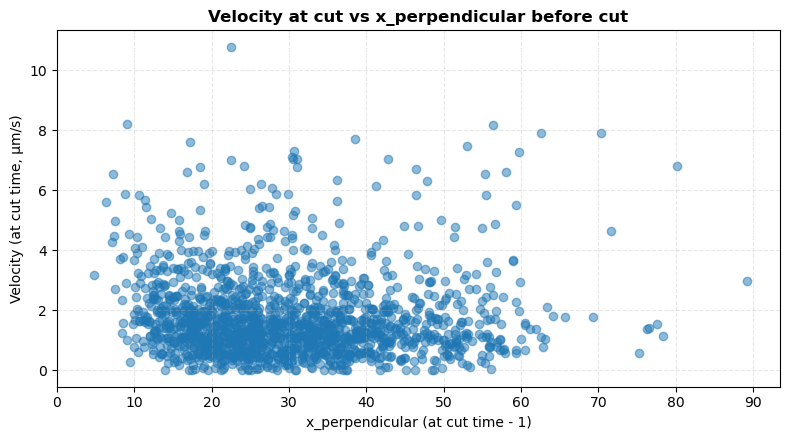

Pearson correlation: -0.0353, p-value: 1.6610e-01


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

df = points_final.copy()

# 1. Identify the cut time for each cell
cut_times = df.loc[df["cut"]].groupby("cell_id")["time"].min()

# 2. Get rows at the cut time (velocity at cut)
cut_df = df[df["time"].isin(cut_times)].copy()

# 3. Get rows at cut time - 1 (x_perpendicular before cut)
precut_df = df.copy()
precut_df["cut_time"] = precut_df["cell_id"].map(cut_times)
precut_df = precut_df[precut_df["time"] == precut_df["cut_time"] - 1]

# 4. Merge precut x_perpendicular with cut velocity
merged = pd.merge(
    cut_df[["point_id", "velocity_cut"]],
    precut_df[["point_id", "x_perpendicular"]],
    on="point_id",
    how="inner"
)

# 5. Drop missing values just in case
merged = merged.dropna(subset=["x_perpendicular", "velocity_cut"])

# Use absolute value
merged["x_perpendicular"] = merged["x_perpendicular"].abs()

# 6. Scatter plot
plt.figure(figsize=(8, 4.5))
plt.scatter(merged["x_perpendicular"], merged["velocity_cut"], alpha=0.5)
plt.xlabel("x_perpendicular (at cut time - 1)")
plt.ylabel("Velocity (at cut time, pixels/s)")
plt.title("Velocity at cut vs x_perpendicular before cut", fontweight="bold")
plt.grid(True, alpha=0.3, linestyle="--")

# Optional: nice ticks on x-axis
min_x = merged["x_perpendicular"].min()
max_x = merged["x_perpendicular"].max()
if max_x > min_x:
    plt.xticks(np.arange(0, np.ceil(max_x) + 10, 10))

plt.tight_layout()
plt.show()

corr, p_value = pearsonr(merged['x_perpendicular'], merged['velocity_cut'])
print(f"Pearson correlation: {corr:.4f}, p-value: {p_value:.4e}")


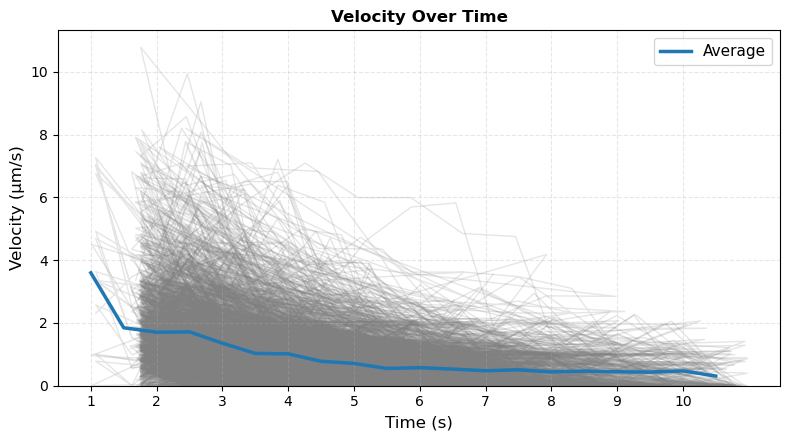

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = points_final.copy()
bin_length = 0.5  # seconds

# Drop NaNs in required columns
df = df.dropna(subset=['velocity_cut', 't_rel'])

plt.figure(figsize=(8, 4.5))

# 1. Plot individual trajectories in the background
for cell_id, group in df.groupby('cell_id'):
    plt.plot(group['t_rel'], group['velocity_cut'],
             color='gray', alpha=0.2, linewidth=1, zorder=1)

# 2. Compute and plot population average
df['ts_bin'] = np.floor(df['t_rel'] / bin_length) * bin_length
avg_data = df.groupby('ts_bin')['velocity_cut'].mean().reset_index()
plt.plot(avg_data['ts_bin'], avg_data['velocity_cut'],
         linewidth=2.5, label='Average', zorder=2)

# 3. Styling
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (pixels/s)', fontsize=12)
plt.title('Velocity Over Time', fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=11)

# X-axis ticks
min_time = df['t_rel'].min()
max_time = df['t_rel'].max()
if max_time > min_time:
    plt.xticks(np.arange(int(np.floor(min_time)), int(np.ceil(max_time)), 1))

# Y-axis
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()
